In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [27]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
# reading the pizza sales dataset
sales = pd.read_csv("/content/Pizza_Sale - pizza_sales.csv")
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [3]:
sales.shape

(48620, 12)

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [5]:
# converting order date and time to datetime fromat
sales['order_date'] = pd.to_datetime(sales['order_date'], format='mixed')
sales['order_time'] = pd.to_datetime(sales['order_time'], format='%H:%M:%S').dt.time
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [6]:
# Checking null values
sales.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,7
pizza_size,0
pizza_category,23


In [7]:
# dropping null values
sales.dropna(inplace=True)

In [8]:
sales.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [9]:
# Checking duplicates
sales.duplicated().sum()

0

In [10]:
# checking orderdate type
sales['order_date'].head()

,order_date
0,2015-01-01
1,2015-01-01
2,2015-01-01
3,2015-01-01
4,2015-01-01


In [11]:
sales.describe()

,pizza_id,order_id,quantity,order_date,unit_price,total_price
count,48554.000000,48554.000000,48554.000000,48554,48554.000000,48554.000000
mean,24342.866458,10715.733081,1.019648,2015-06-29 00:59:45.616015104,16.493957,16.821744
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000
25%,12205.250000,5360.250000,1.000000,2015-03-30 00:00:00,12.750000,12.750000
50%,24343.500000,10702.000000,1.000000,2015-06-28 00:00:00,16.500000,16.500000
75%,36481.750000,16107.750000,1.000000,2015-09-29 00:00:00,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000
std,14017.563232,6172.205962,0.143172,NaN,3.621876,4.438471


In [12]:
# Checking unique values in each column
sales.nunique()

,0
pizza_id,48554
order_id,21326
pizza_name_id,91
quantity,4
order_date,358
order_time,16368
unit_price,25
total_price,56
pizza_size,5
pizza_category,4


# Exploratory Data Analysis (EDA)
Daily sales trend over time

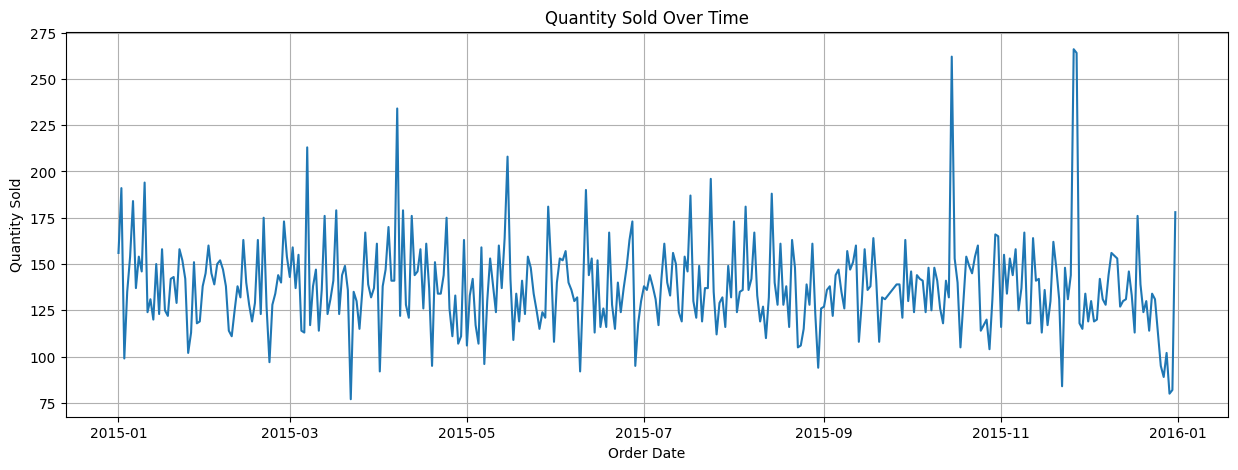

In [14]:
daily_sales = sales.groupby('order_date').agg({'quantity': 'sum'})

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.grid(True)
plt.show()

Top Selling Pizzas

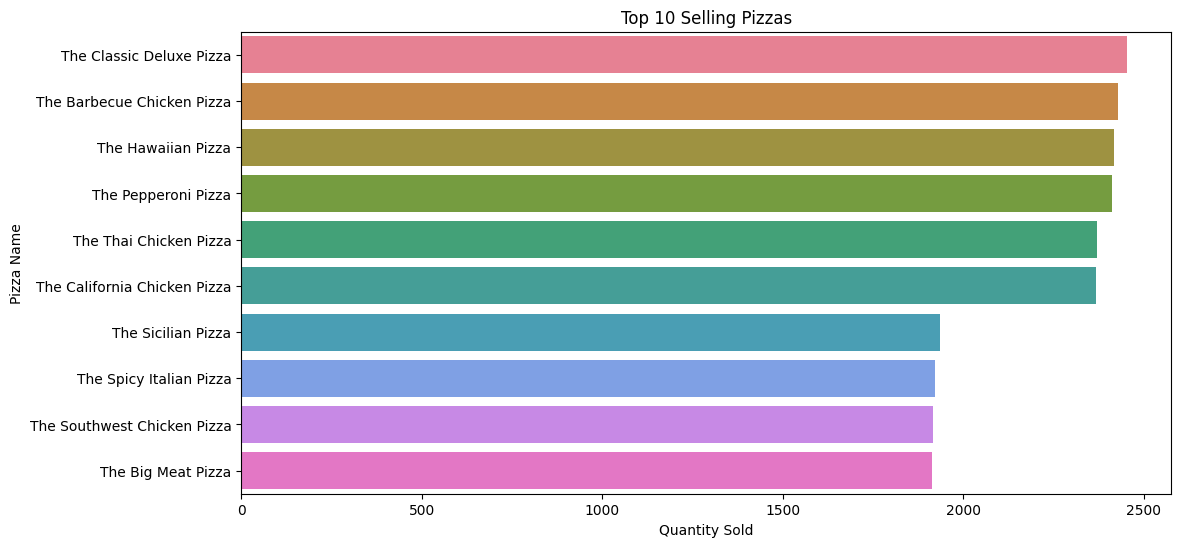

In [16]:
# Group by pizza and calculate total sales
top_pizzas = sales.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False).head(10)

# Plot with multiple colors
plt.figure(figsize=(12, 6))
sns.barplot(x=top_pizzas.values, y=top_pizzas.index, palette="husl")

plt.title('Top 10 Selling Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

Sales by day of week

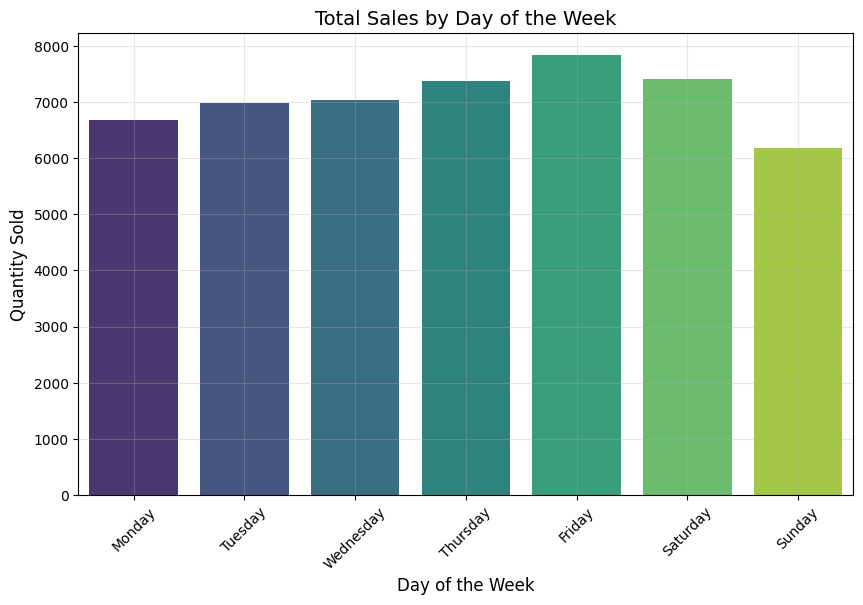

In [17]:
# Add a day of the week column
sales['day_of_week'] = sales['order_date'].dt.day_name()

# Group by day of the week
sales_by_day = sales.groupby('day_of_week').agg({'quantity': 'sum'}).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot sales by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day['quantity'], palette="viridis")
plt.title('Total Sales by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

Sales By Month

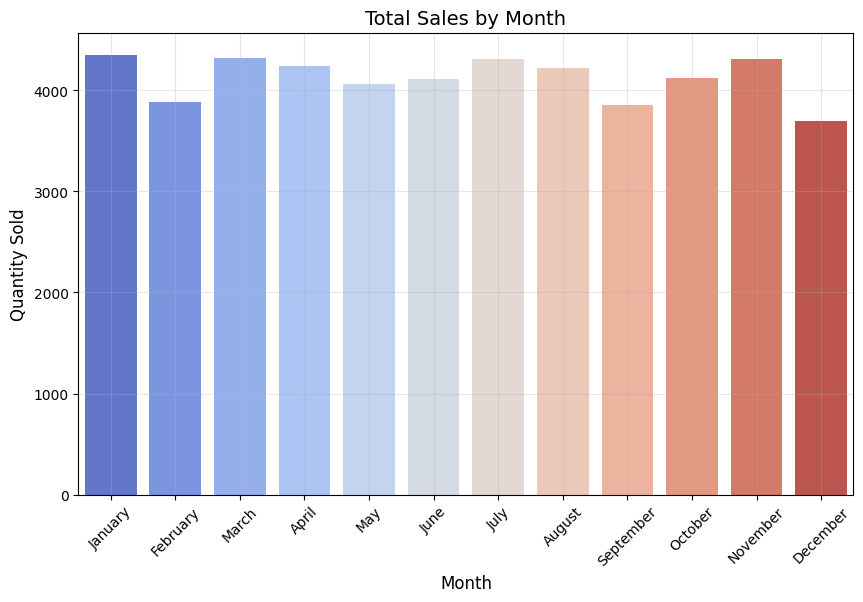

In [18]:
# Add a month column
sales['month'] = sales['order_date'].dt.month_name()

# Group by month
sales_by_month = sales.groupby('month').agg({'quantity': 'sum'}).reindex(
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot sales by month
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_month.index, y=sales_by_month['quantity'], palette="coolwarm")
plt.title('Total Sales by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

Peak selling hours in a day

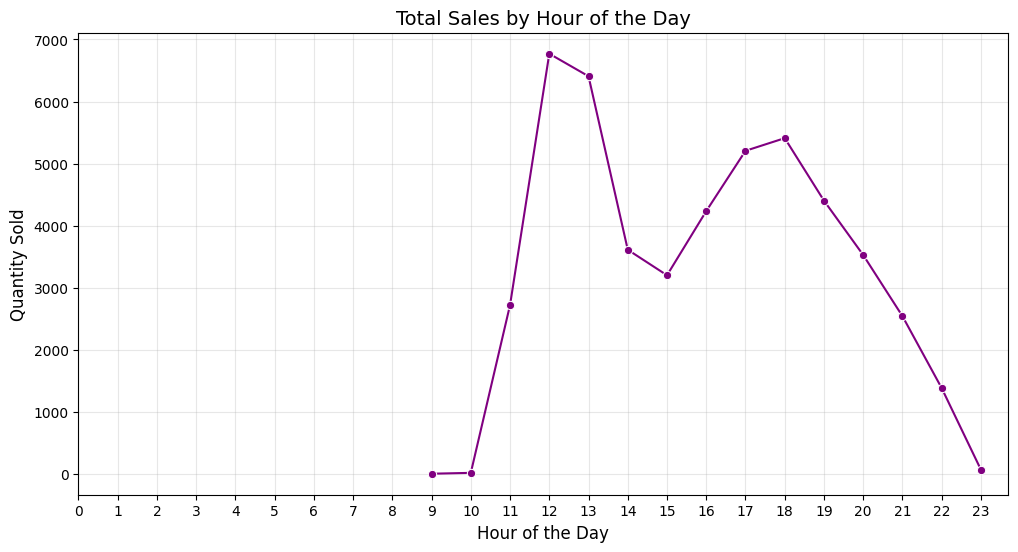

In [19]:
# Extract hour from order time
sales['hour'] = pd.to_datetime(sales['order_time'], format='%H:%M:%S').dt.hour

# Group by hour
sales_by_hour = sales.groupby('hour').agg({'quantity': 'sum'})

# Plot sales by hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=sales_by_hour.index, y=sales_by_hour['quantity'], marker='o', linestyle='-', color='purple')
plt.title('Total Sales by Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(range(0, 24))
plt.show()

In [21]:
# Checking Outliers

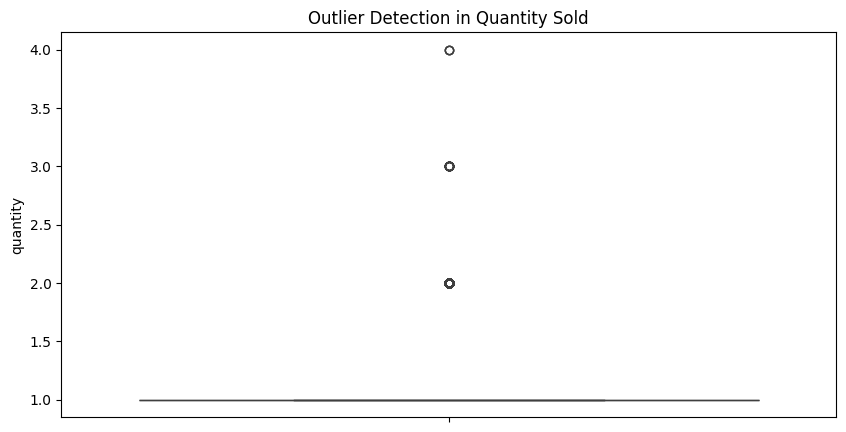

In [22]:
# Plot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(sales['quantity'])
plt.title('Outlier Detection in Quantity Sold')
plt.show()

In [23]:
# Remove extreme outliers if necessary
sales = sales[sales['quantity'] < sales['quantity'].quantile(0.99)]

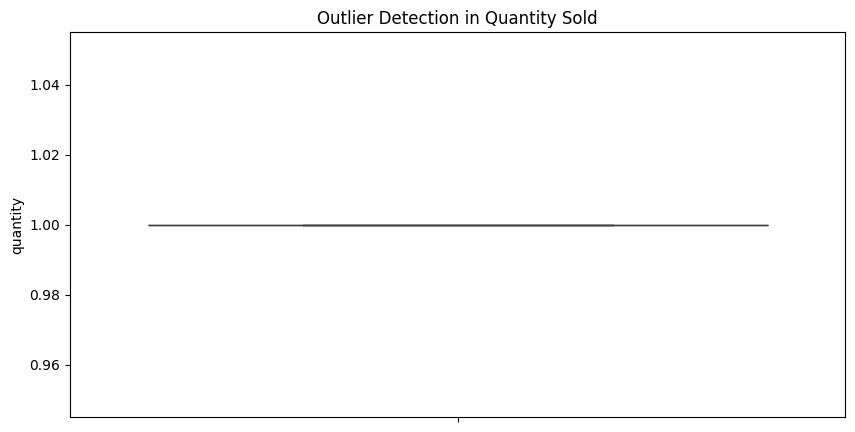

In [24]:
# Plot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(sales['quantity'])
plt.title('Outlier Detection in Quantity Sold')
plt.show()

Stationarity Check

In [25]:
def adf_test(sales):
  result = adfuller(sales)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')

In [29]:
adf_test(daily_sales)

ADF Statistic: -4.919389
p-value: 0.000032
# Lags used: 15
No of observations used: 342
we reject the null hypothesis, The series is stationary


Stationarity Check:
The Augmented Dickey-Fuller (ADF) test was used to determine if the series is stationary. A stationary series has a constant mean and variance over time.

Results:

ADF Statistic: -4.919
p-value: 0.000032
Lags Used: 15
Observations Used: 342
Since the p-value is below 0.05, the null hypothesis is rejected, indicating that the series is stationary and does not require differencing.

Autocorrelation & Partial Autocorrelation:
Autocorrelation Function (ACF):

Shows the correlation between current and past values (lags).
Helps identify q (the number of lagged forecast errors in ARIMA).
Significant lags end where the ACF plot cuts off.
Partial Autocorrelation Function (PACF):

Measures correlation after removing intermediate lag effects.
Helps identify p (the number of lagged terms in ARIMA).
The cutoff point in the PACF plot indicates significant lags.

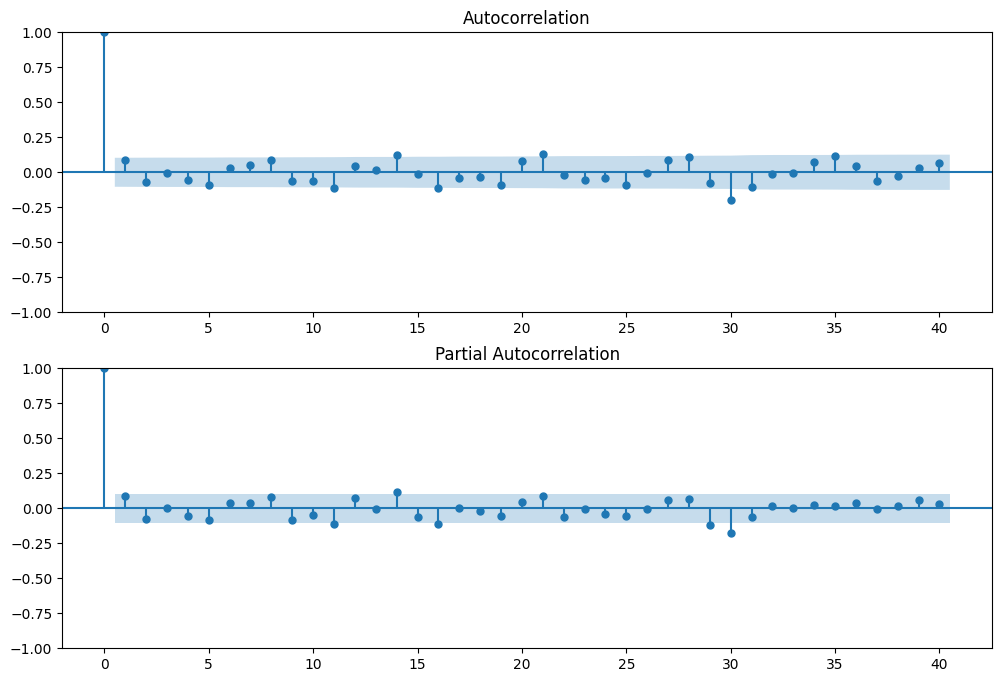

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

# Acf plot
fig = plot_acf(daily_sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)

# pacf plot
fig = plot_pacf(daily_sales, lags=40, ax=ax2)

ACF Plot:

The ACF cuts off sharply after lag 2, indicating that the moving average component q=2. PACF Plot:

The PACF cuts off sharply after lag 1, indicating that the autoregressive component p=1.

# Sales Prediction

In [32]:
data = sales.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)
data.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,12.0,5.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,3.0,0.0,5.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,4.0,6.0,1.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,3.0,9.0,4.0,4.0,...,5.0,5.0,0.0,6.0,5.0,2.0,4.0,5.0,10.0,6.0


In [33]:
one_pizza = data['The Barbecue Chicken Pizza']

In [34]:
# Train-Test Split
train = one_pizza[:-30]  # Use all but the last 30 days for training
test = one_pizza[-30:]

In [35]:
train.isna().sum()

0

In [36]:
train = train.fillna(train.median())

ARIMA Model

In [37]:
print(train.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23',
               '2015-11-24', '2015-11-25', '2015-11-26', '2015-11-27',
               '2015-11-28', '2015-11-29'],
              dtype='datetime64[ns]', name='order_date', length=328, freq=None)


In [38]:
train.index = pd.to_datetime(train.index)
train = train.asfreq('D')  # 'D' for daily, adjust based on your data's frequency

In [39]:
# Fit ARIMA model (order=(1, 1, 1) as a starting point; optimize based on AIC/BIC)
arima_model = ARIMA(train, order=(1, 0, 2))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test))

# Evaluate ARIMA Model
arima_mape = mean_absolute_percentage_error(test, arima_forecast)

print("ARIMA Model MAPE:", arima_mape)

ARIMA Model MAPE: 0.4902134453838462


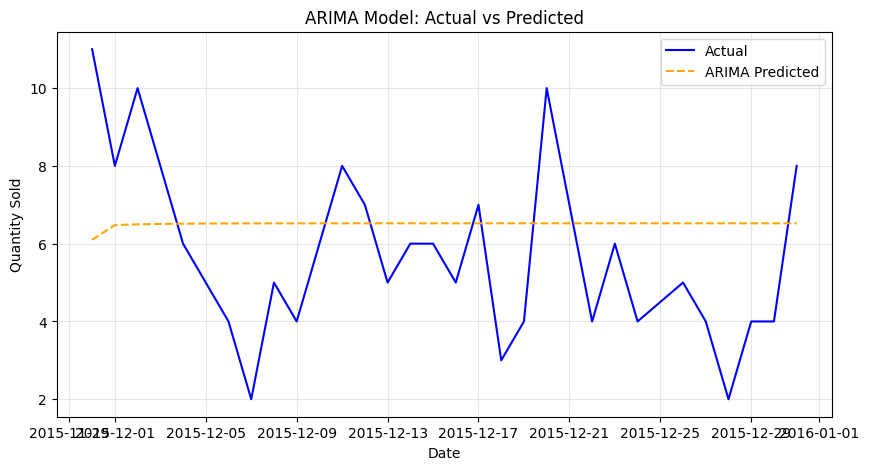

In [40]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Predicted', linestyle='--', color='orange')
plt.title('ARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

ARIMA model is appearing to predict a flat trend, not capturing the variability in actual sales

# SARIMA Model

In [41]:
# Fit SARIMA model (seasonal_order=(1, 1, 1, 7) for weekly seasonality; adjust as needed)
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test))

# Evaluate SARIMA Model
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast)

print("SARIMA Model MAPE:", sarima_mape)

SARIMA Model MAPE: 0.44395823959196173


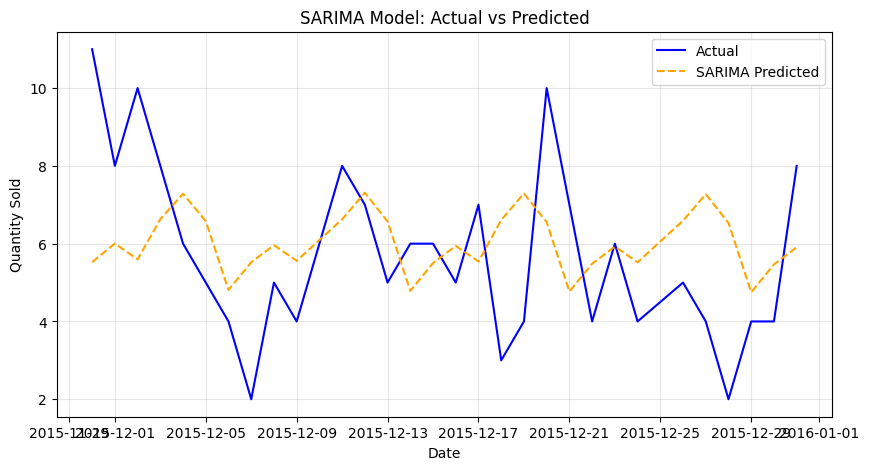

In [42]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, sarima_forecast, label='SARIMA Predicted', linestyle='--', color='orange')
plt.title('SARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

SARIMA predictions show periodic peaks and dips, indicating it captures seasonality better than ARIMA.
However, there’s still a lag in capturing sudden changes in sales

# Prophet Model

In [43]:
from prophet import Prophet
# Prepare data for Prophet
prophet_data = one_pizza.reset_index()
prophet_data.columns = ['ds', 'y']

# Train-Test Split
prophet_train = prophet_data[:-30]
prophet_test = prophet_data[-30:]

# Fit Prophet Model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Forecast
future_dates = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future_dates)

# Extract only test period forecast
prophet_test_forecast = prophet_forecast[-30:]['yhat']

# Evaluate Prophet Model
prophet_mape = mean_absolute_percentage_error(prophet_test['y'], prophet_test_forecast)

print("Prophet Model MAPE:", prophet_mape)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_09_mfl6/2cdck_2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_09_mfl6/j23n66qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43313', 'data', 'file=/tmp/tmp_09_mfl6/2cdck_2u.json', 'init=/tmp/tmp_09_mfl6/j23n66qo.json', 'output', 'file=/tmp/tmp_09_mfl6/prophet_modelpe23t486/prophet_model-20250317081909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:19:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:19:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model MAPE: 0.4372199087540485


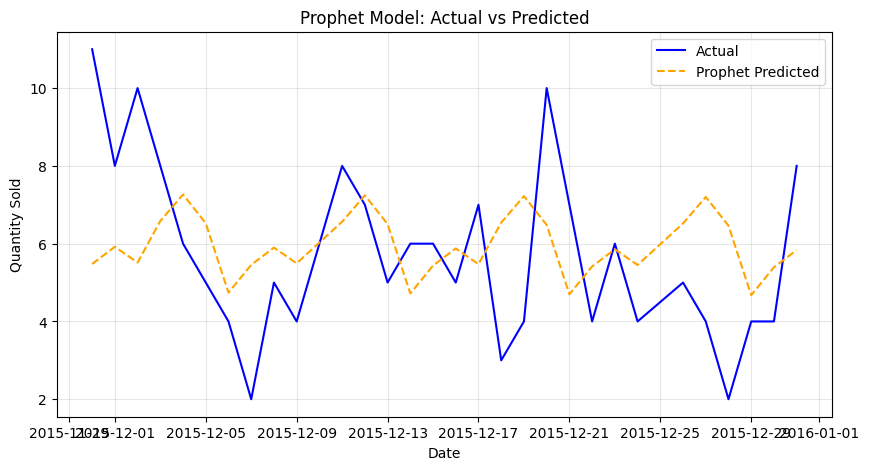

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue')
plt.plot(prophet_test['ds'], prophet_test_forecast, label='Prophet Predicted', linestyle='--', color='orange')
plt.title('Prophet Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Prophet captures seasonal variations well, closely following the periodic fluctuations of actual sales.
Some deviations are present during sharp changes, but overall, Prophet performs robustly

# LSTM

In [45]:
# Normalize data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [46]:
print("NaN in train data:", np.isnan(scaled_train).any())
print("NaN in test data:", np.isnan(scaled_test).any())

NaN in train data: True
NaN in test data: False


In [47]:
scaled_train = np.nan_to_num(scaled_train)
scaled_test = np.nan_to_num(scaled_test)

In [48]:
# Create LSTM dataset
def create_lstm_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1347
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0395
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0347
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0363
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0326
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0334
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0352
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0324
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0357
Epoch 16/20
21/21 ━

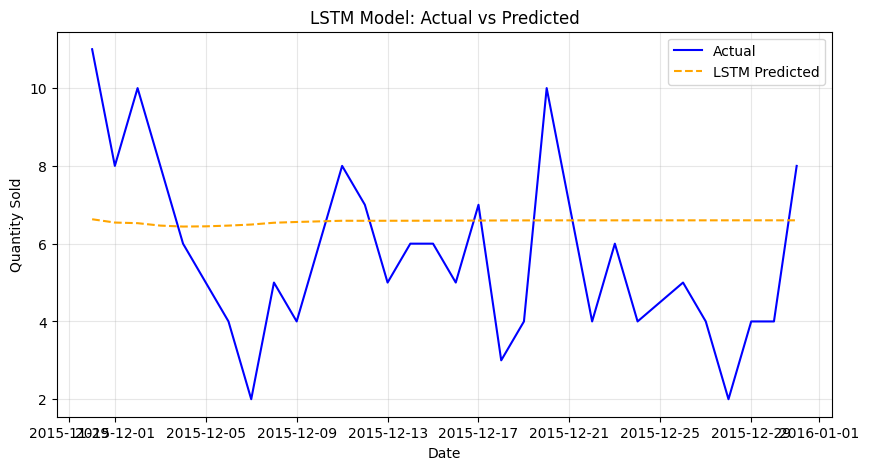

In [49]:
look_back = 10
x_train, y_train = create_lstm_dataset(scaled_train, look_back)
x_test, y_test = create_lstm_dataset(scaled_test, look_back)

# Reshape data for LSTM
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=16, verbose=1)

# Iterative Forecast to Match Test Length
input_sequence = x_test[0].reshape(1, look_back, 1)  # Start with the first sequence in x_test
lstm_forecast_extended = []  # Store all predictions

for _ in range(len(test)):  # Iterate to predict for the entire test length
    # Predict the next value
    predicted_value = model.predict(input_sequence, verbose=0)[0][0]  # Extract scalar prediction
    lstm_forecast_extended.append(predicted_value)

    # Update the input sequence by appending the predicted value and removing the oldest value
    input_sequence = np.append(input_sequence[:, 1:, :], [[[predicted_value]]], axis=1)

# Convert predictions to original scale
lstm_forecast_extended = np.array(lstm_forecast_extended).reshape(-1, 1)
lstm_forecast_extended = scaler.inverse_transform(lstm_forecast_extended)

# Evaluate the LSTM Model
lstm_mape = mean_absolute_percentage_error(test, lstm_forecast_extended.flatten())
print("LSTM Model MAPE:", lstm_mape)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, lstm_forecast_extended.flatten(), label='LSTM Predicted', linestyle='--', color='orange')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

LSTM is struggling to capture the variability in the sales data, showing a flatter prediction

In [50]:
print(f"ARIMA Model MAPE: {arima_mape}")
print(f"SARIMA Model MAPE: {sarima_mape}")
print(f"Prophet Model MAPE: {prophet_mape}")
print(f"LSTM Model MAPE: {lstm_mape}")

ARIMA Model MAPE: 0.4902134453838462
SARIMA Model MAPE: 0.44395823959196173
Prophet Model MAPE: 0.4372199087540485
LSTM Model MAPE: 0.49357735768713135


Based on the provided MAPE (Mean Absolute Percentage Error) values, Prophet has the lowest MAPE, making it the best-performing model for our dataset. Prophet is handling seasonality and trends effectively.

# Sales Forecasting: Predicting pizza sales for the next one week using the trained Prophet model.


In [52]:
from prophet import Prophet
import pandas as pd

# Initialize dictionary to store forecasts
all_forecasts = {}

# Loop through each pizza type
for pizza in data.columns:  # data contains daily sales of each pizza
    one_pizza_sales = data[pizza].reset_index()
    one_pizza_sales.columns = ['ds', 'y']  # Prophet requires columns ['ds', 'y']

    # Initialize Prophet model for each pizza type
    prophet_model = Prophet()
    prophet_model.fit(one_pizza_sales)

    # Forecast for the next 7 days
    future_dates = prophet_model.make_future_dataframe(periods=7)
    forecast = prophet_model.predict(future_dates)

    # Store forecasted values (last 7 days)
    all_forecasts[pizza] = forecast.iloc[-7:]['yhat'].values

# Convert forecasts into a DataFrame
forecast_df = pd.DataFrame(all_forecasts)

# Ensure 'data' has a DateTime index before using Timedelta
data.index = pd.to_datetime(data.index)

forecast_df.index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7)

forecast_df

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_09_mfl6/t1osrs6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_09_mfl6/akxz8fi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2763', 'data', 'file=/tmp/tmp_09_mfl6/t1osrs6t.json', 'init=/tmp/tmp_09_mfl6/akxz8fi4.json', 'output', 'file=/tmp/tmp_09_mfl6/prophet_modeltkmlq4a7/prophet_model-20250317082735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,7.038017,4.950613,1.484723,2.830293,6.831085,3.357073,3.193104,7.652324,3.986706,5.642348,...,4.645561,5.992949,2.857664,5.800013,5.562474,3.406536,2.942635,4.571374,6.730516,4.380261
2016-01-02,6.299290,5.027982,1.217387,2.839403,5.812977,2.940273,2.469718,7.071492,2.943444,5.579987,...,3.736990,5.994352,2.554216,4.977327,5.325855,2.739440,2.346077,3.470677,6.413684,4.366790
2016-01-03,4.700942,4.363161,1.511221,2.281557,5.035797,2.155366,2.500518,5.772955,2.776016,4.391448,...,3.614391,4.345781,2.136208,4.232824,4.235183,2.497882,2.006320,3.366403,5.481310,3.768172
2016-01-04,5.347577,4.650213,1.443491,3.089175,5.952824,2.757610,2.771179,6.810796,3.027739,4.721162,...,3.666138,4.352823,2.137899,5.258976,4.718989,2.448610,2.183903,3.951985,6.850570,3.962708
2016-01-05,5.724399,4.315702,1.583449,2.743205,5.332054,2.498341,2.004962,6.937013,3.580926,4.733678,...,4.218104,4.782772,3.034810,5.073284,5.033716,2.720303,2.211541,3.355172,6.144612,3.542506
2016-01-06,5.399120,4.604380,1.602660,2.897065,5.639628,2.536892,2.762717,6.590466,3.118269,5.271875,...,3.756575,5.398205,2.573203,4.765144,4.994081,2.432319,2.250036,3.835959,5.971621,4.293429
2016-01-07,6.447288,5.007274,1.737835,2.841661,5.995111,2.742686,2.953439,6.938900,3.522719,5.732380,...,3.750958,5.367475,2.601901,5.407122,5.584886,2.637958,2.464121,4.005335,6.519850,4.510529


In [53]:
# Round the forecasted number of pizzas to the nearest whole number
forecast_df = forecast_df.round()

# Display the updated forecast DataFrame
forecast_df

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,7.0,5.0,1.0,3.0,7.0,3.0,3.0,8.0,4.0,6.0,...,5.0,6.0,3.0,6.0,6.0,3.0,3.0,5.0,7.0,4.0
2016-01-02,6.0,5.0,1.0,3.0,6.0,3.0,2.0,7.0,3.0,6.0,...,4.0,6.0,3.0,5.0,5.0,3.0,2.0,3.0,6.0,4.0
2016-01-03,5.0,4.0,2.0,2.0,5.0,2.0,3.0,6.0,3.0,4.0,...,4.0,4.0,2.0,4.0,4.0,2.0,2.0,3.0,5.0,4.0
2016-01-04,5.0,5.0,1.0,3.0,6.0,3.0,3.0,7.0,3.0,5.0,...,4.0,4.0,2.0,5.0,5.0,2.0,2.0,4.0,7.0,4.0
2016-01-05,6.0,4.0,2.0,3.0,5.0,2.0,2.0,7.0,4.0,5.0,...,4.0,5.0,3.0,5.0,5.0,3.0,2.0,3.0,6.0,4.0
2016-01-06,5.0,5.0,2.0,3.0,6.0,3.0,3.0,7.0,3.0,5.0,...,4.0,5.0,3.0,5.0,5.0,2.0,2.0,4.0,6.0,4.0
2016-01-07,6.0,5.0,2.0,3.0,6.0,3.0,3.0,7.0,4.0,6.0,...,4.0,5.0,3.0,5.0,6.0,3.0,2.0,4.0,7.0,5.0


# Ingredient Calculation

In [54]:
ingredients = pd.read_csv('/content/Pizza_ingredients - Pizza_ingredients.csv')
ingredients.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [55]:
ingredients.nunique()

,0
pizza_name_id,91
pizza_name,32
pizza_ingredients,64
Items_Qty_In_Grams,17


In [56]:
ingredient_forecast = []

# Loop through each pizza in forecast_df
for pizza in forecast_df.columns:
    # Get the total forecasted sales for the pizza (sum across 7 days)
    total_sales = forecast_df[pizza].sum()

    # Get the ingredient requirements for the pizza from ingredients_data
    pizza_ingredients = ingredients[ingredients['pizza_name'] == pizza]

    # Calculate total ingredient requirements
    for _, row in pizza_ingredients.iterrows():
        ingredient_forecast.append({
            'ingredient': row['pizza_ingredients'],  # Ingredient name
            'quantity_needed': total_sales * row['Items_Qty_In_Grams']  # Forecast * quantity per pizza
        })

# Convert to DataFrame
ingredient_forecast_df = pd.DataFrame(ingredient_forecast)

# Summarize by ingredient
final_purchase_order = ingredient_forecast_df.groupby('ingredient').agg({'quantity_needed': 'sum'}).reset_index()

# Add a unit column (e.g., grams)
final_purchase_order['unit'] = 'grams'

# Display the final purchase order
print("Final Purchase Order:")
pd.set_option('display.max_rows',64)
final_purchase_order

Final Purchase Order:


,ingredient,quantity_needed,unit
0,?duja Salami,2400.0,grams
1,Alfredo Sauce,855.0,grams
2,Anchovies,2295.0,grams
3,Artichokes,6705.0,grams
4,Arugula,870.0,grams
5,Asiago Cheese,3660.0,grams
6,Bacon,18180.0,grams
7,Barbecue Sauce,1200.0,grams
8,Barbecued Chicken,3600.0,grams
9,Beef Chuck Roast,15960.0,grams
